# OnlineSuperLearner example project
In this notebook we present a very basic example of how the OnlineSuperLearner (OSL) can be used. The goal of OSL is to be able to make predictions and do inference on time series data. In order to do so it estimates a density function for each of the covariates, the treatment variables and the outcome. After these densities are fitted, OSL can simulate interventions and determine the outcome given such an intervention.

## This notebook
In this notebook we will present the steps needed to perform a basic simulation. We will start by installing and configurint the package. Then we approximate our true parameter of interest given the simulation data. This approximated truth is used as ground truth for the rest of the algorithm. In the next step we estimate the densities and run an iteritative sampling method, in which we apply the same treatment as in the approximation step. If everything goes well, both parameters should be approximately the same. Note that this notebook does not apply any TMLE.

## Install dependencies
Before anything else we need to install several dependencies. Most dependencies are used by OSL and some are used by TMLEnet. 

In [2]:
# Define the packages we want to install
# Set the can mirror
options(repos = structure(c(CRAN = "http://cran-mirror.cs.uu.nl/")))

gh_packages <- list(
  list(repo = "frbl/tmlenet", branch = 'fb-add-update'),
  list(repo = "frbl/OnlineSuperLearner", branch = 'master')
)

packages <- c("devtools","mockery","RCurl","jsonlite","data.table","R.utils","R.methodsS3","R.oo","simcausal",
              "xgboost","nnls","sgd","dplyr","magrittr","optimr","nloptr","purrr","doParallel","foreach","matrixStats",
              "digest","future")

In [ ]:
install <- function(packages, installfunc, ...){
  new.packages <- packages[!(packages %in% installed.packages()[, "Package"])]
  if (length(new.packages))
    installfunc(new.packages, ...)
  update.packages(lib.loc = Sys.getenv("R_LIBS_USER"), ask = FALSE)
}

install(packages, install.packages)
lapply(gh_packages, function(pkg) install(pkg$repo, devtools::install_github, ref = pkg$branch))

# Specific packages
# Finds and remove any previously installed H2O packages for R.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, we download, install and initialize the H2O package for R.
#install.packages("h2o", repos=(c("http://s3.amazonaws.com/h2o-release/h2o/rel-kahan/5/R", getOption("repos"))))
install.packages("h2o", type="source", repos=(c("http://h2o-release.s3.amazonaws.com/h2o/rel-tverberg/2/R")))

And then load the actual packages

In [3]:
# Set a seed and genereal helpers, load the packages
set.seed(12345)
expit = plogis
logit = qlogis

packages <- c('tmlenet', 'OnlineSuperLearner', packages)
invisible(lapply(packages, require, character.only = TRUE))

Loading required package: tmlenet
tmlenet
The tmlenet package is still in beta testing. Interpret results with caution.
Loading required package: OnlineSuperLearner
Loading required package: R6
Loading required package: devtools
Loading required package: mockery
Loading required package: RCurl
Loading required package: bitops
Loading required package: jsonlite
Loading required package: data.table
Loading required package: R.utils
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.21.0 (2016-10-30) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:RCurl’:

    clone

The following objects are masked from ‘package:devtools’:

    check, unload

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, gc, load, save

R.

## Configuration
The next step is to configure several parameters for the estimation procedure itself.

In [4]:
# Do logging?
log <- FALSE

# Should TMLE fit our estimators in parallel?
tmlenet_options(parfit=FALSE)

# How many cores would we like to use?
cores = parallel::detectCores()

# Number of items we have in our testset
training_set_size <- 200

# Number of iterations we want to use (this is for the online training part)
max_iterations = 3

# The calculator for estimating the risk
cv_risk_calculator <- OnlineSuperLearner:::CrossValidationRiskCalculator$new()

Now the basic configuration for the OSL is done, we can go ahead and specify which intervention we are interested in. Interventions are specified as an R `list` with three elements:
1. _when_: When should the intervention be done? (i.e., at what time $t$)
2. _what_: What should be the intervention we are doing? (e.g., set treatment to $x \in \{0,1\}$)
3. _variable_: Which variable do we consider the intervention variable? ($A$ in the TL literature)

In [5]:
# Number of iterations for approximation of the true parameter of interest
B <- 1e3

# The intervention we are interested in
intervention  <- list(when = c(2), what = c(0), variable ='A')

# The time of the outcome
tau = 2

## Simulation
In order to have some data to use for testing, we have to create a simulator. This simulator uses the simulation scheme as defined in _Blaauw, Chambaz and van der Laan, in prep._. For this scheme we can define various things for each of the data generating systems:
1. _stochMech_: the mechanism we use to generate the observations
2. _param_: the number of steps $t$ the mechanism is connected to the past
3. _rgen_: the mechanism for generating the observations

In [6]:
# Our covariate definition
llW <- list(
  stochMech=function(numberOfBlocks) {
    rnorm(numberOfBlocks, 0, 10)
  },
  param=c(0, 0.5, -0.25, 0.1),
  rgen=identity
)

# The treatment mechanism
llA <- list(
  stochMech=function(ww) {
    rbinom(length(ww), 1, expit(ww))
  },
  param=c(-0.1, 0.1, 0.25),
  rgen=function(xx, delta=0.05){
    probability <- delta+(1-2*delta)*expit(xx)
    rbinom(length(xx), 1, probability)
  }
)

# The outcome variable
llY <- list(
  rgen={function(AW){
    aa <- AW[, "A"]
    ww <- AW[, grep("[^A]", colnames(AW))]
    mu <- aa*(0.4-0.2*sin(ww)+0.05*ww) + (1-aa)*(0.2+0.1*cos(ww)-0.03*ww)
    #mu <- aa*(0.9) + (1-aa)*(0.3)
    rnorm(length(mu), mu, sd=0.1)}
  }
)

Now, using these mechanisms we need to setup our simulator. First we define the 'truth', or in our case, an approximation of the true parameter of interest. This parameter specifies what we expect to receive if we would run the earlier specified intervention

In [7]:
# Create the simulator
simulator  <- OnlineSuperLearner::Simulator.GAD$new()


# Approximate the truth under the treatment
result.approx <- mclapply(seq(B), function(bb) {
  when <- max(intervention$when)
  data.int <- simulator$simulateWAY(tau, qw = llW, ga = llA, Qy = llY,
                                    intervention = intervention, verbose = log)
  data.int$Y[tau]
}, mc.cores = cores) %>%
  unlist

psi.approx <- mean(result.approx)

print(psi.approx)

[1] 0.1944428


The next step is to use the mechanisms to create a test set of data. Note that we are wrapping our data in a `Data.Static` object. By doing so, we can easily swap this static dataframe out for a stream of incoming data.

In [8]:
data.train <- simulator$simulateWAY(training_set_size + B, qw=llW, ga=llA, Qy=llY, verbose=log)
data.train.static <- OnlineSuperLearner::Data.Static$new(dataset = data.train)

## The OnlineSuperLearner initialization
Now everything is set-up, we can start our super learner procedure. First let's choose a set of estimators we wish to include in our learner. Note that OSL automatically creates a grid of learners based on te hyperparameters provided in the setup.

In [9]:
algos <- list()
#algos <- list(list(description='ML.H2O.randomForest-1tree',
                      #algorithm = 'ML.H2O.randomForest',
                      #params = list(ntrees = 1)))

#algos <- append(algos, list(list(description='ML.H2O.randomForest-50trees',
                      #algorithm = 'ML.H2O.randomForest',
                      #params = list(ntrees = 50))))

#algos <- append(algos, list(list(description='ML.H2O.gbm',
                      #algorithm = 'ML.H2O.gbm')))

#algos <- append(algos, list(list(algorithm = 'ML.XGBoost',
                      #algorithm_params = list(alpha = 0),
                      #params = list(nbins = c(6,40), online = TRUE))))

#algos <- append(algos, list(list(algorithm = 'ML.H2O.gbm',
                      #algorithm_params = list(ntrees=c(10,20), min_rows=1),
                      #params = list(nbins = c(6), online = TRUE))))

#algos <- append(algos, list(list(algorithm = 'ML.H2O.randomForest',
                      #algorithm_params = list(ntrees=c(10,20)),
                      #params = list(nbins = c(6), online = TRUE))))

algos <- append(algos, list(list(algorithm = 'tmlenet::speedglmR6',
                      #algorithm_params = list(),
                      params = list(nbins = c(3,4, 5), online = FALSE))))

#algos <- append(algos, list(list(algorithm = 'tmlenet::glmR6',
                      ##algorithm_params = list(),
                      #params = list(nbins = c(16, 20, 24, 30, 34, 40), online = FALSE))))

We use the loglikelihood loss function as general loss function. In order to do so, we should make sure that we bound all variables between $0$ and $1$. We create bounds for all variables in order to do so.

In [10]:
bounds <- OnlineSuperLearner:::SummaryMeasureGenerator.generate_bounds(data.train)

The next step is to define our random variables. In this example we only consider the default variables $W$, $A$, and $Y$. Each of them is univariate, and the $A$ variable is a binary variable. Currently we only support the variable at time $t$ ($W$, $A$, or $Y$) and a lagged version therof ($*\_lag\_*$, e.g., $A\_lag\_1$):

In [11]:
W <- RandomVariable$new(formula = Y ~ A + W, family = 'gaussian')
A <- RandomVariable$new(formula = A ~ W + Y_lag_1 + A_lag_1 + W_lag_1, family = 'binomial')
Y <- RandomVariable$new(formula = W ~ Y_lag_1 + A_lag_1 +  W_lag_1 + Y_lag_2, family = 'gaussian')
randomVariables <- c(W, A, Y)

Then we need to create a system that will define our summary measure generator. This step is a bit cumbersome and will be removed in later versions. The idea is that given the definition provided in the previous code block, we have to generate several variables (e.g. the lags). In order to do so, we use a SummaryMeasureGenerator, which will parse these formulae and create the necessary summary measures.

In [12]:
smg_factory <- SMGFactory$new()
summaryMeasureGenerator <- smg_factory$fabricate(randomVariables, bounds = bounds)

The last step is to actually run and fit our SuperLearner and calculate its CV risk:

In [13]:
osl  <- OnlineSuperLearner$new(algos, summaryMeasureGenerator = summaryMeasureGenerator, verbose = log)
risk <- osl$fit(data.train.static, randomVariables = randomVariables,
                initial_data_size = training_set_size / 2,
                max_iterations = max_iterations,
                mini_batch_size = (training_set_size / 2) / max_iterations)

Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the border, so doing nothing... 
”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in chol.default(B, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”Warning message in private$perform_optimization(weights = private$weights, epsilon = private$epsilon, :
“
 Trying to start from the

In order to see how well it can estimate we sample from our estimates:

In [14]:
datas <- summaryMeasureGenerator$getNext(n = B)
result <- mclapply(seq(B), 
  function(i) {
    osl$sample_iteratively(data = datas[i,],
                           randomVariables = randomVariables,
                           intervention = intervention,
                           tau = tau)
  }, mc.cores=cores) %>%
  lapply(., function(x) { tail(x, 1)$Y }) %>%
  unlist

Warning message in data.table::data.table(...):
“Item 1 is of size 962 but maximum size is 964 (recycled leaving remainder of 2 items)”

And to see the results, we plot them:

[1] "We have approximated psi as 0.194442821945586 our estimate is 0.322414455187017 which is a difference of: 0.127971633241431"


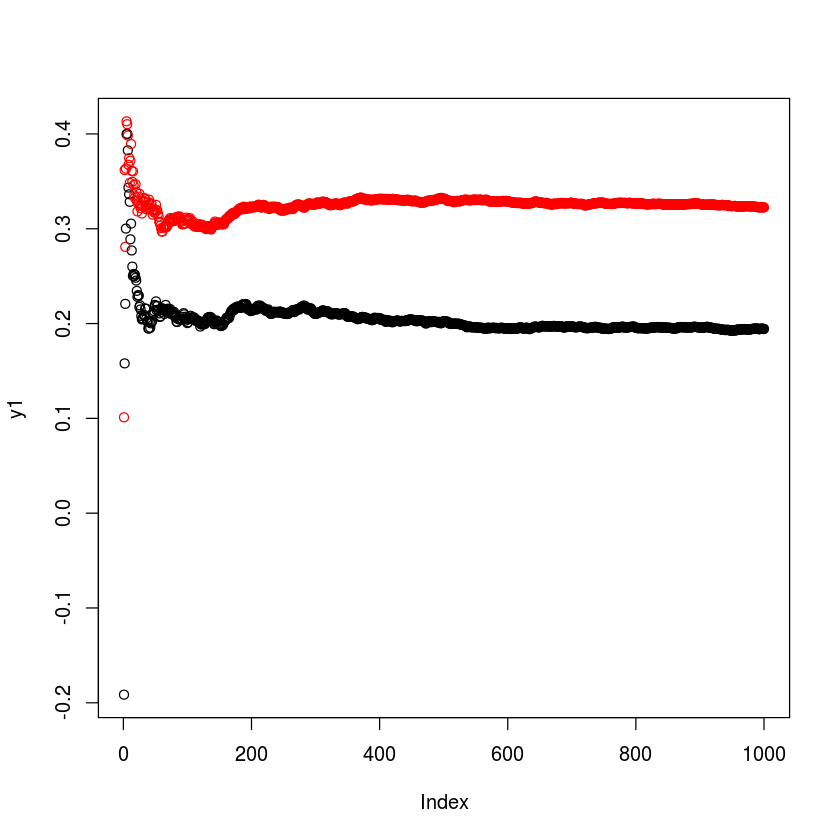

In [20]:
# Calculate psi
psi.estimation <- mean(result)

# Plot the convergence
y1 <- cumsum(result.approx)/seq(along=result.approx)
y2 <- cumsum(result)/seq(along=result)

plot(y1, ylim=range(c(y1,y2)))
par(new=TRUE)
plot(y2, ylim=range(c(y1,y2)), col="red", axes = FALSE, xlab = "", ylab = "")

# Print the outcome
print(paste('We have approximated psi as', psi.approx, 
            'our estimate is', psi.estimation, 
            'which is a difference of:', abs(psi.approx - psi.estimation)))